In [1]:
import nltk 
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np
import math
import torch
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec


nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/aditya/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/aditya/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [11]:
tagged_sents = nltk.corpus.brown.tagged_sents(tagset = "universal") 
# print(tagged_sents[505])

words = []
tags = []

for i in tagged_sents:
    words_sent =[]
    tags_sent = []
    for j in i:
        words_sent.append(j[0])
        tags_sent.append(j[1])
    words.append(words_sent)
    tags.append(tags_sent)


In [12]:
class HMM_Pos():
    def __init__(self, ts):
        self.wordTags = defaultdict(Counter)
        self.transCount = defaultdict(Counter)
        tups = [tup for x in ts for tup in x]
        self.posCount = Counter(tag for word, tag in tups)
        for word, tag in tups:
            self.wordTags[word][tag] += 1
        for ls in ts:
            for i in range(len(ls)-1):
                self.transCount[ls[i][1]][ls[i+1][1]] += 1    
    
    def wordGivenTag(self, tag, word):
        num = self.wordTags[word][tag] # can be zero if word is new or comb never appears
        total = self.posCount[tag] # always not zero 
        p = (num + 1)/(total + 1 + len(self.wordTags))
        return p
    
    def tagGivenPrevTag(self, tag1, tag2):
        num = self.transCount[tag1][tag2] # can be zero 
        total = self.posCount[tag1] # always not zero
        p = (num + 1)/(total + len(self.posCount))
        return p
    
    def assignTag(self, uSen):
        n = len(uSen)
        s = defaultdict(Counter)
        
        for tag in self.posCount:
            s[0][tag] = 0.0
        s[0][startToken] = 0.0
        
        bptr = defaultdict(Counter)
        bptr[0][startToken] = 0
        
        for i in range(1, n-1):
            word = uSen[i]
            for tag in self.posCount:
                s[1][tag] = 1
                for pTag in self.posCount:
                    sProb = math.log(self.wordGivenTag(tag, word)) + math.log(self.tagGivenPrevTag(pTag, tag)) + s[0][pTag]
                    if s[1][tag] == 1.0:
                        s[1][tag] = sProb
                        bptr[i][tag] = pTag
                    elif s[1][tag] < sProb:
                        s[1][tag] = sProb
                        bptr[i][tag] = pTag
                        
            for tag in self.posCount:
                s[0][tag] = s[1][tag]
         
        ans = [endToken for i in range(n)]
        
        for tag in self.posCount:
            if s[1][tag] > s[1][ans[n-2]]:
                ans[n-2] = tag
        
        for i in range(n-3, 0, -1):
            ans[i] = bptr[i+1][ans[i+1]]
        
        ans[0] = startToken
        return ans

In [13]:
class viterbivec():

    def __init__(self, ts):
        self.wordTags = defaultdict(Counter)
        self.transCount = defaultdict(Counter)
        tups = [tup for x in ts for tup in x]
        self.posCount = Counter(tag for word, tag in tups)
        for word, tag in tups:
            self.wordTags[word][tag] += 1
        for ls in ts:
            for i in range(len(ls)-1):
                self.transCount[ls[i][1]][ls[i+1][1]] += 1    
    

    def Viterbi_vec(words, test): 

        tokens, tag = zip(*words)
        v_size = 60

        data_w = []
        temp_w = []
        n_w = len(tokens)
        for i in range(n_w):
            temp_w.append(tokens[i])
            if tokens[i] == ".":
                data_w.append(temp_w)
                temp_w = []
        data_w.append(temp_w)
        model_train = gensim.models.Word2Vec(data_w, min_count = 1, vector_size = v_size, window = 5)

        data_t = []
        temp_t = []
        n_t = len(test)
        for i in range(n_t):
            temp_t.append(test[i][0])
            if test[i][0] == ".":
                data_t.append(temp_t)
                temp_t = []
        data_t.append(temp_t)
        model_test = gensim.models.Word2Vec(data_t, min_count = 1, vector_size = v_size, window = 5)
        


        tag_count, tag_freq = tag_frequency(tag, words)
        emission_probability = emission_probs(tokens, words, tag_count)
        transition_probability = transition_probs(tag, words, tag_count)

        per_pos = dict.fromkeys(tag_freq.keys(), 0.0)
        per_pos_count = dict.fromkeys(tag_freq.keys(), 0)
        pred = []

        score = 0.0
        viterbi = {}
        for tag_i in tagset:
        viterbi[tag_i] = transition_probability["."][tag_i]

        k = 1
        n = len(test)
        for i in range(n):

            maxi = 0.0
            max_tag = "tag"
            c = False

            for tag_i in tagset:
                em = emission_probability[test[i][0]][tag_i]

                if em != 0:
                    c = True

            if not c:
                lst = list(test[i])
                lst[0] = model_train.wv.similar_by_vector(model_test.wv[test[i][0]], topn=1)[0][0]
                test[i] = tuple(lst)

            viterbi_h = {}
            for tag_i in tagset:    
                em = emission_probability[test[i][0]][tag_i]
                val = viterbi[tag_i]*em*100
                viterbi_h[tag_i] = val
                
                if val >= maxi:
                    maxi = val
                    max_tag = tag_i


            per_pos_count[test[i][1]] = per_pos_count[test[i][1]] + 1
            pred.append(max_tag)

            if max_tag == test[i][1]:
                per_pos[test[i][1]] = per_pos[test[i][1]] + 1.0
                score = score + 1.0


            viterbi_next = dict.fromkeys(tagset, 0)
            for tag_i in tagset:
                for tag_j in tagset:
                    viterbi_next[tag_j] = max(viterbi_next[tag_j], viterbi_h[tag_i]*transition_probability[tag_i][tag_j])

            if k%7 == 0:
                k = 0
                viterbi = tag_freq.copy()
            
            else:
                viterbi = viterbi_next

            k = k+1

        for tag_i in tagset:
            per_pos[tag_i] = per_pos[tag_i]/per_pos_count[tag_i]

        return score*100/n, per_pos, pred

IndentationError: expected an indented block after 'for' statement on line 54 (2243025368.py, line 55)

In [9]:
kFold = KFold(n_splits=5, shuffle=True, random_state=1)
tSents = np.array(ts, dtype=object)
yPreds = []
yTrues = []
hmm_models = []

In [10]:
for fold, (train, test) in enumerate(kFold.split(tSents)):
    trainSent = tSents[train]
    testSent = tSents[test]
    
    hmm_models.append(HMM_Pos(trainSent))
    yPred, yTrue = [],[]
    
    for sent in (testSent):
        uSent = [word for word, tag in sent]
        out = hmm_models[-1].assignTag(uSent)
        for i in range(1, len(out)-1):
            yPred.append(out[i])
            yTrue.append(sent[i][1])
    
    yPreds.append(np.array(yPred))
    yTrues.append(np.array(yTrue))
    
    acc = np.sum(yTrues[-1] == yPreds[-1])/len(yTrues[-1])
    print(f'Fold {fold + 1} Accuracy : {acc}')

In [ ]:
def getScores(yTrue, yPred, tags):
    right, wrong = {}, {}
    for tag in tags:
        right[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(yTrue, yPred):
        if tag in right and tag == pred:
            right[tag] += 1
        elif tag in wrong:
            wrong[tag] += 1
            
    scores = []
    total = len(yTrue)
    for tag in tags:
        cur = np.array([right[tag], wrong[tag]])
        scores.append(cur / (right[tag] + wrong[tag]))
    return np.array(scores)

In [ ]:
def plotConfusionMatrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)


In [ ]:
def plotCLFReport(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score', 'F0.5-Score','F2-Score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(5), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)

    thresh = np.max(plotMat) / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png')


In [ ]:
def plotTagScores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png')
    plt.show()

In [ ]:
def getReport(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')
    
    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        
        #print(v)
        
        
        if len(v) == 1 : v = v * 3
        x,y = v[0],v[1]
        # f 0.5
        v += [round((1.25*x*y)/((0.25*x) + y),2)]
        # f 2
        v += [round((5*x*y)/((4*x) + y),2)]
        #print(v)
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    
    return class_names, plotMat, support


In [ ]:
tagset = list(hmm_models[-1].posCount.keys())
tagset.remove(startToken)
tagset.remove(endToken)
tagset = sorted(tagset)
print(tagset)

['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [ ]:
tags = tagset
class_names = None
report = None
support = None
cm, scores = None, None
cnt = 0
for yTrue, yPred in zip(yTrues, yPreds):
    class_names, report_, support_ = getReport(yTrue, yPred, tags)
    #print(report_)
    cm_ = confusion_matrix(yTrue, yPred, labels=tags)
    scores_ = getScores(yTrue, yPred, tags)
    
    if report is None : report = np.zeros_like(report_, dtype=np.float64)
    report += report_
    
    if support is None : support = np.zeros_like(support_, dtype=np.float64)
    support += support_
    
    if cm is None : cm = np.zeros_like(cm_, dtype=np.float64)
    cm += cm_
    
    if scores is None : scores = np.zeros_like(scores_, dtype=np.float64)
    scores += scores_
    
    cnt += 1
    
report /= cnt
support /= cnt
cm /= cnt
scores /= cnt

<Figure size 640x480 with 0 Axes>

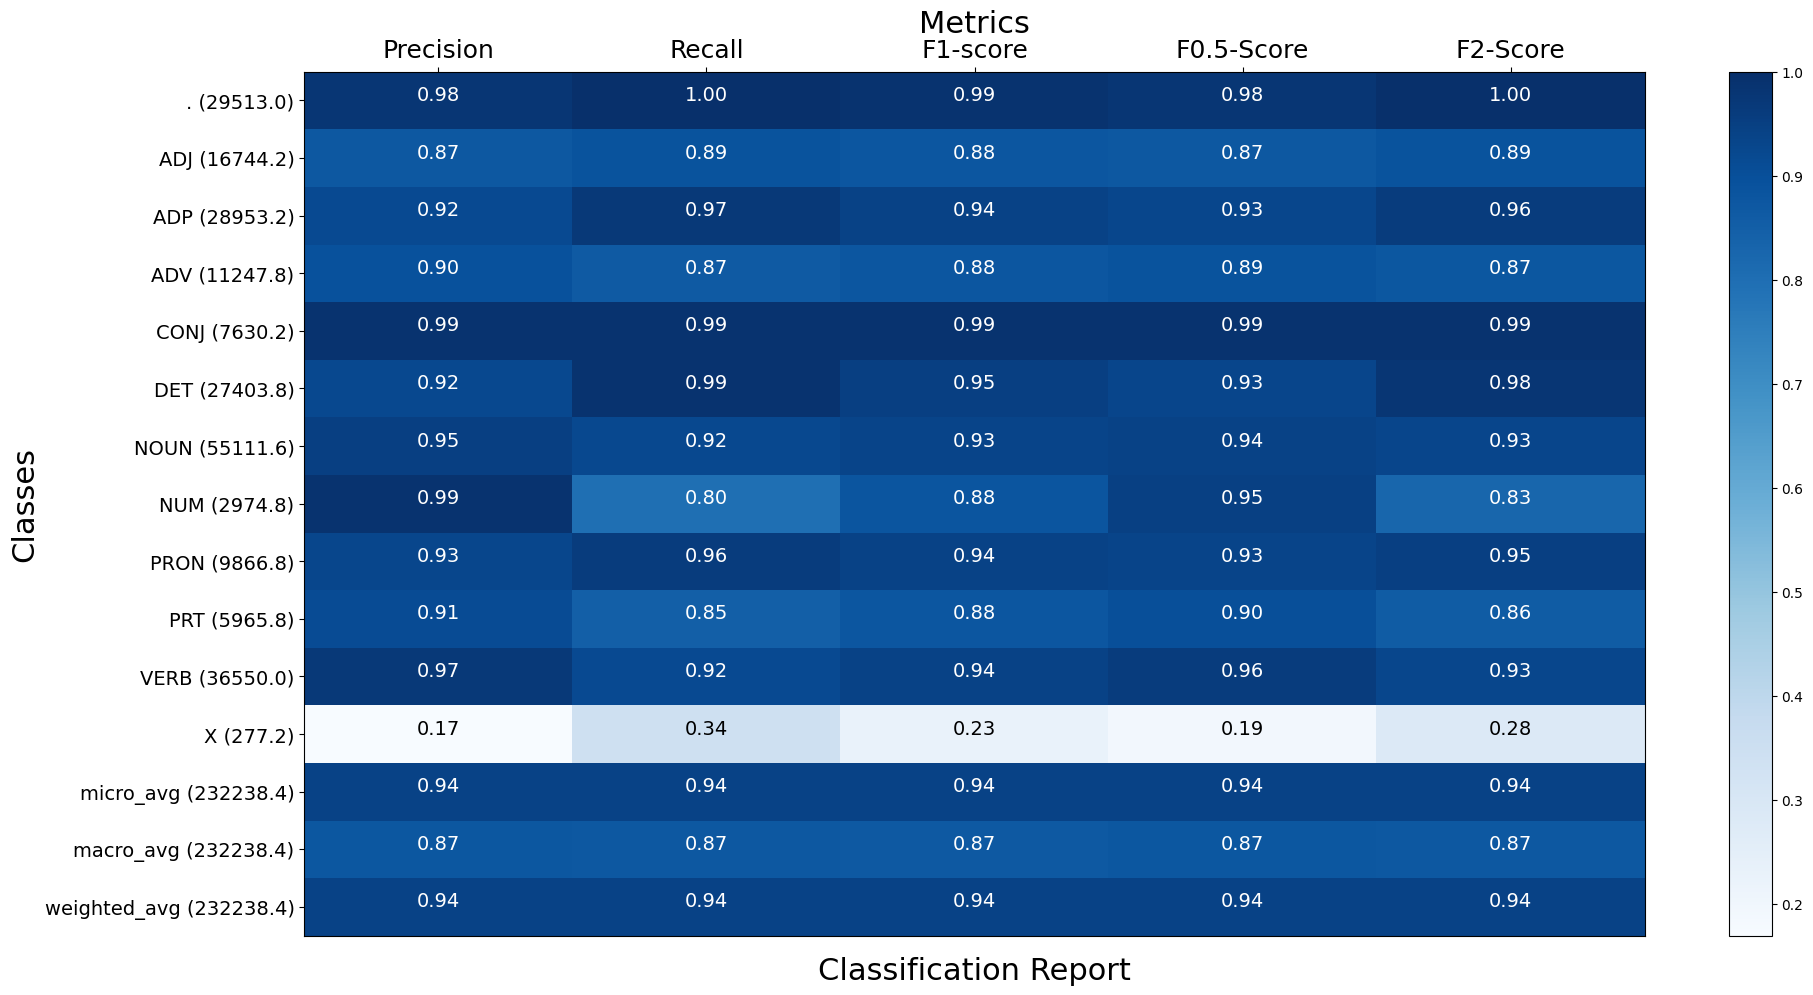

In [ ]:
plotCLFReport(class_names, report, support)

<Figure size 640x480 with 0 Axes>

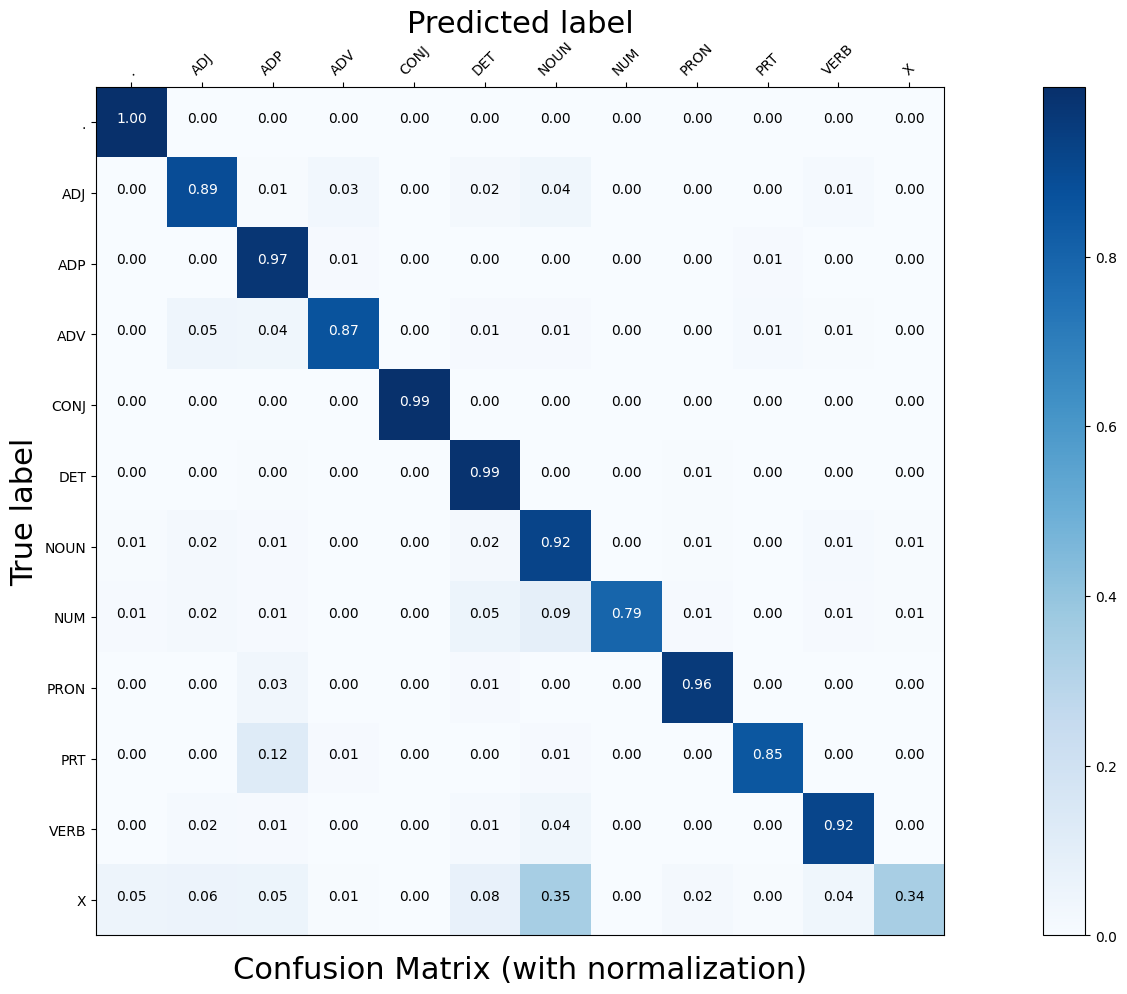

In [ ]:
plotConfusionMatrix(tags, cm)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

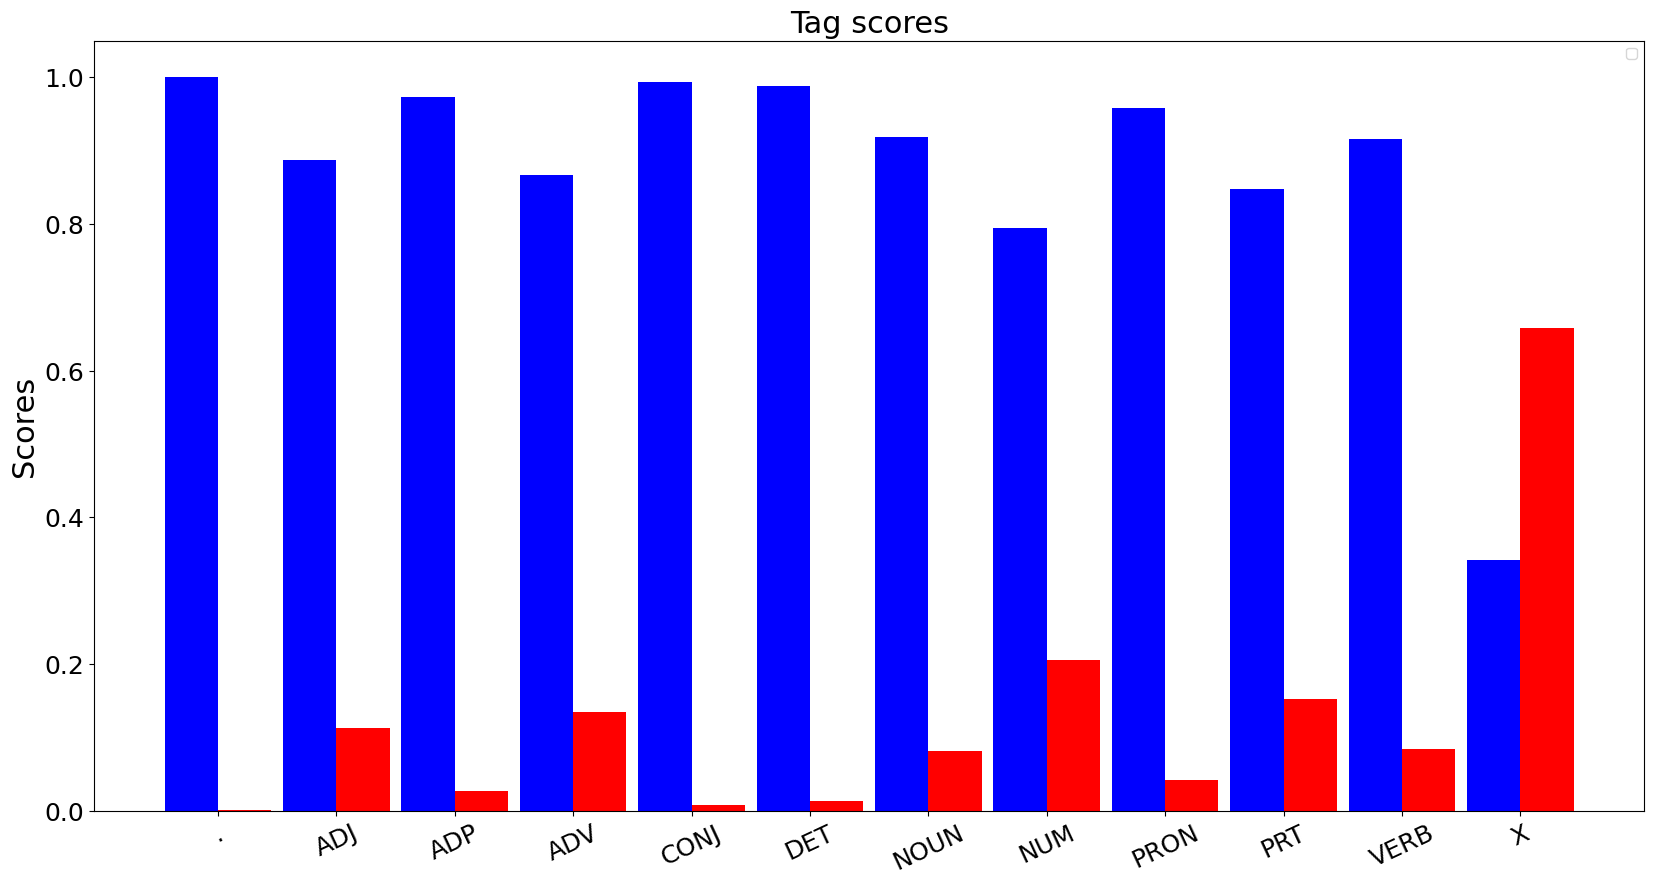

In [ ]:
plotTagScores(tags, scores)

In [ ]:
s = [('^', '^'), ('In', 'ADP'), ('his', 'DET'), ('only', 'ADJ'), ('attack', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('Republicans', 'NOUN'), (',', '.'), ('Hughes', 'NOUN'), ('said', 'VERB'), (',', '.'), ('``', '.'), ('The', 'DET'), ('three', 'NUM'), ('Republican', 'NOUN'), ('candidates', 'NOUN'), ('for', 'ADP'), ('governor', 'NOUN'), ('are', 'VERB'), ('tripping', 'VERB'), ('over', 'ADP'), ('their', 'DET'), ('feet', 'NOUN'), ('for', 'ADP'), ('popular', 'ADJ'), ('slogans', 'NOUN'), ('to', 'PRT'), ('win', 'VERB'), ('the', 'DET'), ('primary', 'NOUN'), ('.', '.'), ('$', '$')]

def func(s):
    words = []
    tags = []
    for word, tag in s:
        words += [word]
        tags += [tag]
    
    return words, tags

words, tags = func(s)
words = [x.lower() for x in words]
# print(words)
# print(words)
# print(tags)

output = hmm_models[-1].assignTag(words)
r = 0
w = 0
for i in range(len(output)):
    if output[i] == tags[i]:
        r +=1
    else:
        w +=1
# print(output)
# print(tags)

print(f"accuracy: {r/(r+w)}")

accuracy: 0.9696969696969697


In [ ]:
text = "he is a good friend of yash ."
text = text.split()
text = [x.lower() for x in text]
text = ['^'] + text + ['$']
print(text)

random = hmm_models[-1].assignTag(text)
print(random)
print(len(random))
print(len(text))

['^', 'he', 'is', 'a', 'good', 'friend', 'of', 'yash', '.', '$']
['^', 'PRON', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', '.', '$']
10
10
